# Analysis of post-workshop survey data which we collect 3-6 months after an in-person/online workshop

In [137]:
from dataclasses import dataclass

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [138]:
# larger font in seaborn plots
sns.set(font_scale=2)

In [139]:
# reduce annoying differences in column titles
def normalize_column_title(s):
    s = s.replace("Post-workshop survey: ", "")
    s = s.replace("Background information: ", "")
    s = s.replace("Impact of the workshop: ", "")
    return s

## Job title/ position/ occupation

In [140]:
def extract_typeform_positions(file_name):
    _df = pd.read_csv(file_name)
    # in these datasets the "other" is a separate column
    # in this case fill the "non-other" column with the value from "other"
    _df["What is your current position?"].fillna(_df["Other"], inplace=True)
    return _df.loc[:,["Which workshop did you attend?","What is your current position?"]]

In [141]:
def extract_indico_positions(file_name):
    _df = pd.read_csv(file_name)
    _df = _df.rename(normalize_column_title, axis='columns')
    return _df.loc[:,["Which workshop did you attend?","What is your current position?"]]

In [142]:
# use filter regarding to focus on specific workshop, e.g. online

def positions_filter(filter):
    positions = pd.concat([
        extract_typeform_positions("data/typeform/2017.csv"),
        extract_typeform_positions("data/typeform/2018.csv"),
        extract_indico_positions("data/indico/2018.csv"),
        extract_indico_positions("data/indico/2019-a.csv"),
        extract_indico_positions("data/indico/2019-b.csv"),
        # 2019-d-2021.csv is updated data exported on the 9th September 2021
        extract_indico_positions("data/indico/2019-d-2021.csv"),
    ])
    positions_filtered = positions[positions["Which workshop did you attend?"].str.contains(filter, case=False)]
    return positions_filtered["What is your current position?"]

values summing up to 316


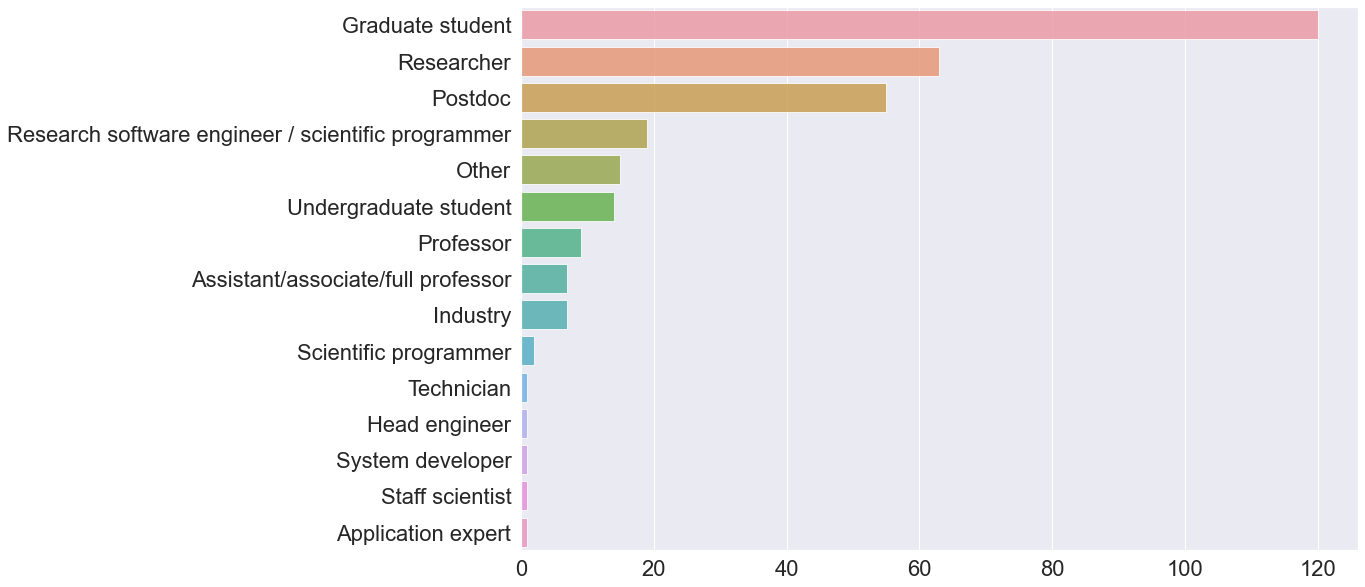

In [143]:
# positions of all the participants
counts_filtered = positions_filter("").value_counts()
unique_positions = positions_filter("").unique()

f, ax = plt.subplots(figsize=(15, 10))

sns.barplot(y=counts_filtered.index.str.capitalize(), x=counts_filtered.values, alpha=0.8)

f.savefig("figures/position.png", bbox_inches = 'tight')

print(f"values summing up to {sum(counts_filtered.values)}")

values summing up to 80


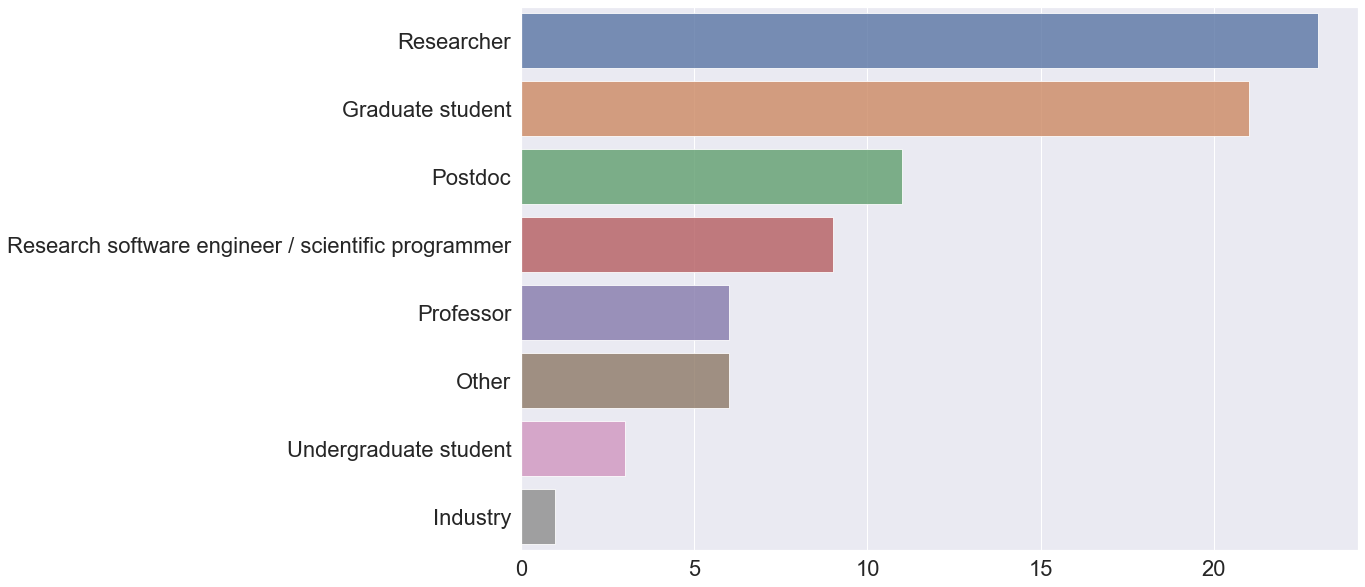

In [144]:
# Focus on online-workshop attendees.
# Use positions_filter() function using "online" as a filtering key-word picked up in workshop information column.

counts_filtered = positions_filter("online").value_counts()
unique_positions = positions_filter("online").unique()

# Make a bar graph of online-workshop attendees' background
f, ax = plt.subplots(figsize=(15, 10))

sns.barplot(y=counts_filtered.index.str.capitalize(), x=counts_filtered.values, alpha=0.8)

f.savefig("figures/position-online.png", bbox_inches = 'tight')

print(f"values summing up to {sum(counts_filtered.values)}")

## Impact on code quality and collaboration

I didn't use mean() because this gave a different result since it would
ignore those rows where there is no answer and only consider rows with 0 or 1.

In [145]:
@dataclass
class QualityCount:
    reusable: int = 0
    reproducible: int = 0
    modular: int = 0
    documented: int = 0
    easier_to_collaborate: int = 0
    introduced_colleagues: int = 0
    def add(self, other):
        self.reusable += other.reusable
        self.reproducible += other.reproducible
        self.modular += other.modular
        self.documented += other.documented
        self.easier_to_collaborate += other.easier_to_collaborate
        self.introduced_colleagues += other.introduced_colleagues

In [146]:
def extract_indico_code_quality(file_name,filter):
    _df = pd.read_csv(file_name)
    _df = _df.rename(normalize_column_title, axis='columns')
    _df = _df[_df['Which workshop did you attend?'].str.contains(filter, case=False)]

    count = QualityCount()
    
    for line in _df["Would you judge your code to be better reusable/reproducible/modular/documented as a result of attending the workshop?"]:
        if "More reusable" in line:
            count.reusable += 1
        if "More reproducible" in line:
            count.reproducible += 1
        if "More modular" in line:
            count.modular += 1
        if "Better documented" in line:
            count.documented += 1

    for line in _df["Has it become easier for you to collaborate on software development with your colleagues and collaborators?"]:
        if "Yes" in line:
            count.easier_to_collaborate += 1        

    for line in _df["Have you introduced one or more of your colleagues to new tools or practices as a result of the workshop?"]:
        if "Yes" in line:
            count.introduced_colleagues += 1 
            
    return count

In [147]:
def extract_typeform_code_quality(file_name,filter):
    _df = pd.read_csv(file_name)
    _df = _df[_df['Which workshop did you attend?'].str.contains(filter, case=False)]

    count = QualityCount()
    
    count.reusable += int(_df["Reusable"].sum())
    count.reproducible += int(_df["Reproducible"].sum())
    count.modular += int(_df["Modular"].sum())
    count.documented += int(_df["Documented"].sum())

    c = [col for col in _df.columns if 'easier for you to collaborate' in col][0]
    count.easier_to_collaborate += int(_df[c].sum())
    
    c = [col for col in _df.columns if 'introduced one or more' in col][0]
    count.introduced_colleagues += int(_df[c].sum())

    return count

In [148]:
# use filter regarding to focus on specific workshop, e.g. online

def calc_num_answers(filter):
    num_answers = 0

    for file_name in [
        "data/typeform/2017.csv",
        "data/typeform/2018.csv",
        "data/indico/2018.csv",
        "data/indico/2019-a.csv",
        "data/indico/2019-b.csv",
        # "data/indico/2019-c-2020.csv",
        "data/indico/2019-d-2021.csv",
    ]:
        _df = pd.read_csv(file_name)
        _df = _df.rename(normalize_column_title, axis='columns')
        _df = _df[_df['Which workshop did you attend?'].str.contains(filter, case=False)]
        num_answers += _df.shape[0]

    print(f"number of survey respondents: {num_answers}")
    return num_answers

In [149]:
def calc_count(filter):
    count = QualityCount()

    count.add(extract_typeform_code_quality("data/typeform/2017.csv",filter))
    count.add(extract_typeform_code_quality("data/typeform/2018.csv",filter))  

    count.add(extract_indico_code_quality("data/indico/2018.csv",filter))
    count.add(extract_indico_code_quality("data/indico/2019-a.csv",filter))
    count.add(extract_indico_code_quality("data/indico/2019-b.csv",filter))
    # count.add(extract_indico_code_quality("data/indico/2019-c-2020.csv"))
    count.add(extract_indico_code_quality("data/indico/2019-d-2021.csv",filter))
    return count

In [150]:
def calc_yesno(count, num_answers):
    yesno = pd.DataFrame(columns = ['Question', 'Fraction'])

    yesno = yesno.append({'Question': 'More reusable?',
                          'Fraction': count.reusable/num_answers},
                         ignore_index = True)
    yesno = yesno.append({'Question': 'More reproducible?',
                          'Fraction': count.reproducible/num_answers},
                         ignore_index = True)
    yesno = yesno.append({'Question': 'More modular?',
                          'Fraction': count.modular/num_answers},
                         ignore_index = True)
    yesno = yesno.append({'Question': 'Better documented?',
                          'Fraction': count.documented/num_answers},
                         ignore_index = True)
    yesno = yesno.append({'Question': 'Easier to collaborate?',
                          'Fraction': count.easier_to_collaborate/num_answers},
                         ignore_index = True)
    yesno = yesno.append({'Question': 'Introduced tools to colleagues?',
                          'Fraction': count.introduced_colleagues/num_answers},
                         ignore_index = True)
    return yesno

In [151]:
# based on all the respondents

num_answers = calc_num_answers("")
count = calc_count("")
yesno = calc_yesno(count, num_answers)

number of survey respondents: 317


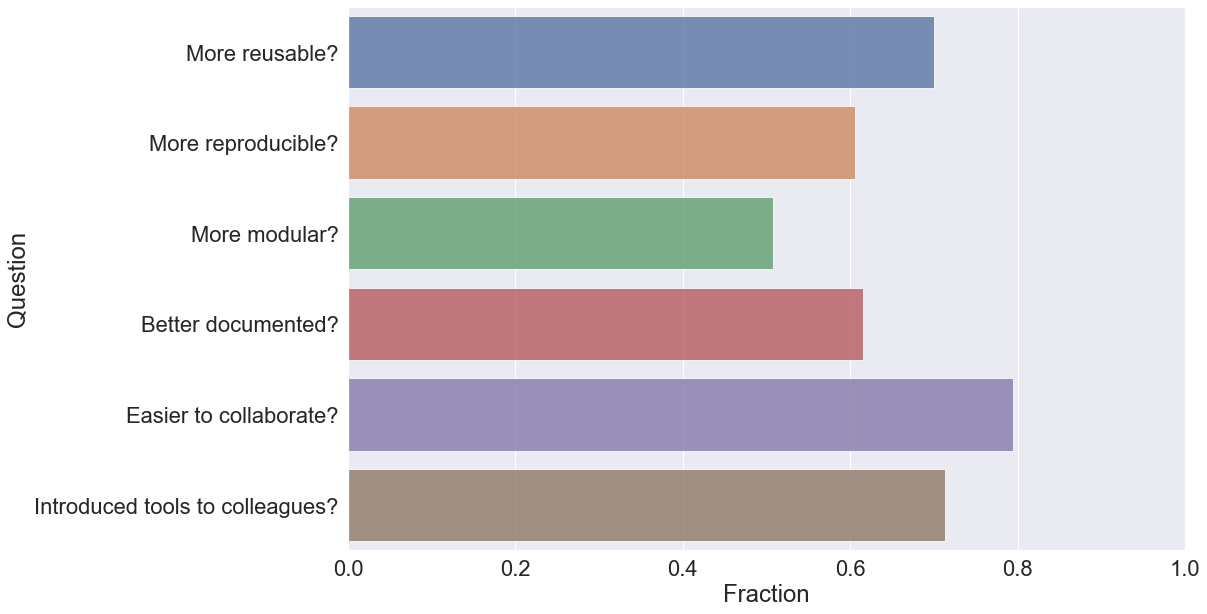

In [152]:
f, ax = plt.subplots(figsize=(15, 10))

g = sns.barplot(y=yesno.Question, x=yesno.Fraction, alpha=0.8)
g.set(xlim=(0.0, 1.0))

f.savefig("figures/yes-no-questions.png", bbox_inches = 'tight')

In [153]:
# Graph based on online-workshop attendees' responses

num_answers = calc_num_answers("online")
count = calc_count("online")
yesno = calc_yesno(count, num_answers)

number of survey respondents: 80


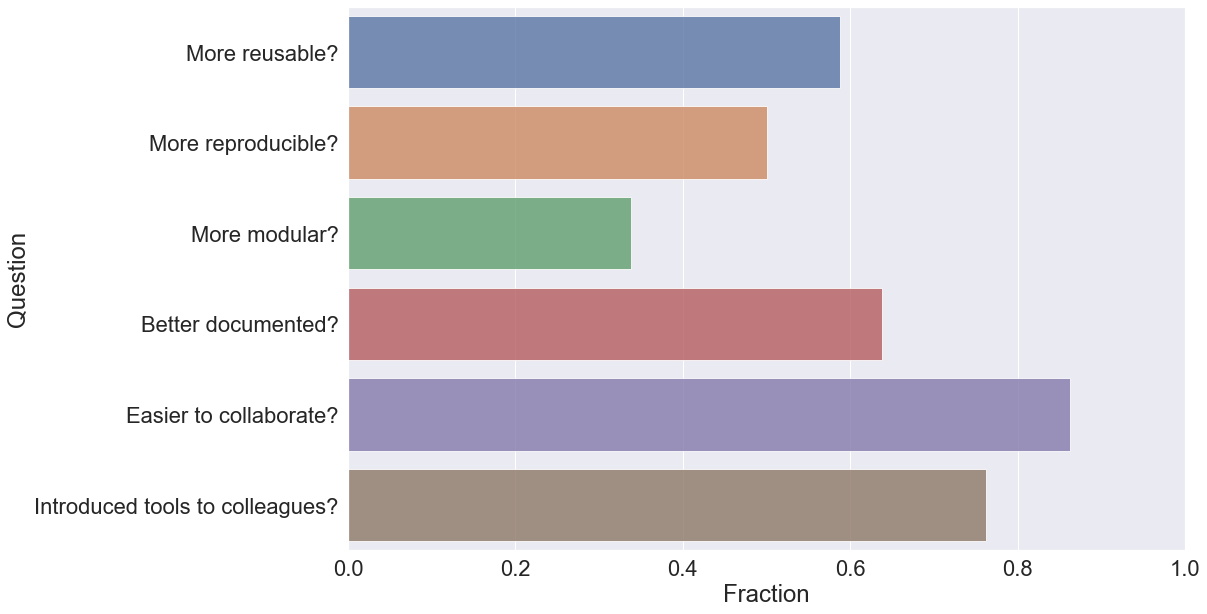

In [154]:
f, ax = plt.subplots(figsize=(15, 10))

g = sns.barplot(y=yesno.Question, x=yesno.Fraction, alpha=0.8)
g.set(xlim=(0.0, 1.0))

f.savefig("figures/yes-no-questions-online.png", bbox_inches = 'tight')

## Impact on usage of software development tools

In [155]:
@dataclass
class ToolCount:
    not_using: int = 0
    started: int = 0
    better: int = 0
    unchanged: int = 0
    def add(self, other):
        self.not_using += other.not_using
        self.started += other.started
        self.better += other.better
        self.unchanged += other.unchanged

In [156]:
def impact_tool_typeform(file_name, tool, filter):
    _df = pd.read_csv(file_name)
    _df = _df[_df['Which workshop did you attend?'].str.contains(filter, case=False)]
    
    count = ToolCount()

    count.not_using += len(_df[_df[tool].str.contains("don't use")])
    count.started += len(_df[_df[tool].str.contains("started using")])
    count.better += len(_df[_df[tool].str.contains("better than before")])
    count.unchanged += len(_df[_df[tool].str.contains("same way as before")])

    return count

In [157]:
def impact_tool_indico(file_name, tool, filter):
    _df = pd.read_csv(file_name)
    _df = _df.rename(normalize_column_title, axis='columns')
    _df = _df[_df['Which workshop did you attend?'].str.contains(filter, case=False)]

    count = ToolCount()

    c = [col for col in _df.columns if 'not using' in col]
    if len(c) > 0:
        count.not_using += len(_df[_df[c[0]].str.contains(tool)])
    c = [col for col in _df.columns if 'not yet using' in col]
    if len(c) > 0:
        count.not_using += len(_df[_df[c[0]].str.contains(tool)])
    
    c = [col for col in _df.columns if 'started using as a result' in col]
    count.started += len(_df[_df[c[0]].str.contains(tool)])

    c = [col for col in _df.columns if 'are you using better' in col]
    count.better += len(_df[_df[c[0]].str.contains(tool)])

    c = [col for col in _df.columns if 'same way as' in col]
    count.unchanged += len(_df[_df[c[0]].str.contains(tool)])

    return count

In [158]:
def impact_tool(file_name, tool, filter):
    if "indico" in file_name:
        return impact_tool_indico(file_name, tool, filter)
    elif "typeform" in file_name:
        return impact_tool_typeform(file_name, tool, filter)

In [159]:
# use filter regarding to focus on specific workshop, e.g. online

def impact_count(filter):

    typeform_files = [
        "data/typeform/2017.csv",
        "data/typeform/2018.csv",
    ]

    indico_files = [
        "data/indico/2018.csv",
        "data/indico/2019-a.csv",
        "data/indico/2019-b.csv",
    #    "data/indico/2019-c-2020.csv",
        "data/indico/2019-d-2021.csv",
    ]

    all_files = typeform_files + indico_files

    d = {}

    d["Version control"] = ToolCount()
    for file_name in all_files:
        d["Version control"].add(impact_tool(file_name, "Version control", filter))

    d["Automated testing"] = ToolCount()
    for file_name in typeform_files:
        d["Automated testing"].add(impact_tool(file_name, "Automated testing", filter))
        d["Automated testing"].add(impact_tool(file_name, "Travis CI", filter))
    for file_name in indico_files:
        d["Automated testing"].add(impact_tool(file_name, "Automated testing", filter))

    d["Coverage"] = ToolCount()
    for file_name in all_files:
        d["Coverage"].add(impact_tool(file_name, "Code coverage analysis", filter))  

    d["Jupyter"] = ToolCount()
    for file_name in all_files:
        d["Jupyter"].add(impact_tool(file_name, "Jupyter Notebooks", filter))  

    # CMake is not part of survey covering online workshops
        d["CMake"] = ToolCount()
    for file_name in all_files:
        d["CMake"].add(impact_tool(file_name, "CMake", filter))  

    # not part of typeform data
    d["Workflows"] = ToolCount()
    for file_name in indico_files:
        d["Workflows"].add(impact_tool(file_name, "Workflow", filter))  

    # IDEs are not part of survey covering online workshops 
    d["IDEs"] = ToolCount()
    for file_name in all_files:
        d["IDEs"].add(impact_tool(file_name, "Integrated development environments", filter))

    d["Code review"] = ToolCount()
    for file_name in all_files:
        d["Code review"].add(impact_tool(file_name, "Code review", filter))

    d["Deploying documentation"] = ToolCount()
    for file_name in indico_files:
        d["Deploying documentation"].add(impact_tool(file_name, "Read the Docs", filter))  
        d["Deploying documentation"].add(impact_tool(file_name, "Read the docs", filter))  
    # Survey respondents misunderstood the question on "GitHub/GitLab/Bitbucket Pages" in the 2017 survey
    # RB: can we explain here why we think this question was misunderstood?
    d["Deploying documentation"].add(impact_tool("data/typeform/2017.csv", "Read the docs", filter))
    d["Deploying documentation"].add(impact_tool("data/typeform/2018.csv", "Read the Docs or GitHub/GitLab/BitBucket Pages", filter))
    
    return d

In [160]:
# based on all the respondents

d = impact_count("")

table = pd.DataFrame(columns = ['Tool', 'Impact', 'Count'], dtype="float")
for k, v in d.items():
    table = table.append({'Tool': k, 'Impact': 'Not using', 'Count': v.not_using}, ignore_index = True)
    table = table.append({'Tool': k, 'Impact': 'Started using', 'Count': v.started}, ignore_index = True)
    table = table.append({'Tool': k, 'Impact': 'Using better', 'Count': v.better}, ignore_index = True)
    table = table.append({'Tool': k, 'Impact': 'Unchanged', 'Count': v.unchanged}, ignore_index = True)
    
result = table.pivot(index='Tool', columns='Impact', values='Count')    

# make sure tools are listed in the same order as added further up
result = result[::-1]

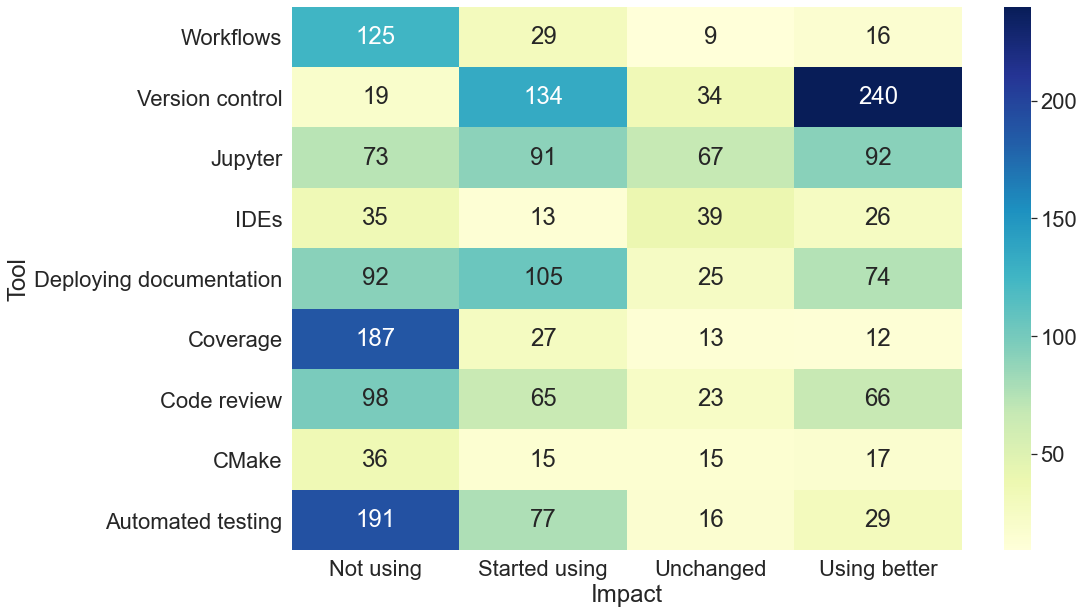

In [161]:
f, ax = plt.subplots(figsize=(15, 10))

g = sns.heatmap(result, fmt="g", cmap="YlGnBu", annot=True)
g.set_yticklabels(g.get_yticklabels(), rotation=0) 

f.savefig("figures/heatmap.png", bbox_inches = 'tight')

In [162]:
# Graph based on online-workshop attendees' responses

d = impact_count("online")

table = pd.DataFrame(columns = ['Tool', 'Impact', 'Count'], dtype="float")
for k, v in d.items():
    table = table.append({'Tool': k, 'Impact': 'Not using', 'Count': v.not_using}, ignore_index = True)
    table = table.append({'Tool': k, 'Impact': 'Started using', 'Count': v.started}, ignore_index = True)
    table = table.append({'Tool': k, 'Impact': 'Using better', 'Count': v.better}, ignore_index = True)
    table = table.append({'Tool': k, 'Impact': 'Unchanged', 'Count': v.unchanged}, ignore_index = True)
    
result = table.pivot(index='Tool', columns='Impact', values='Count')    

# make sure tools are listed in the same order as added further up
result = result[::-1]

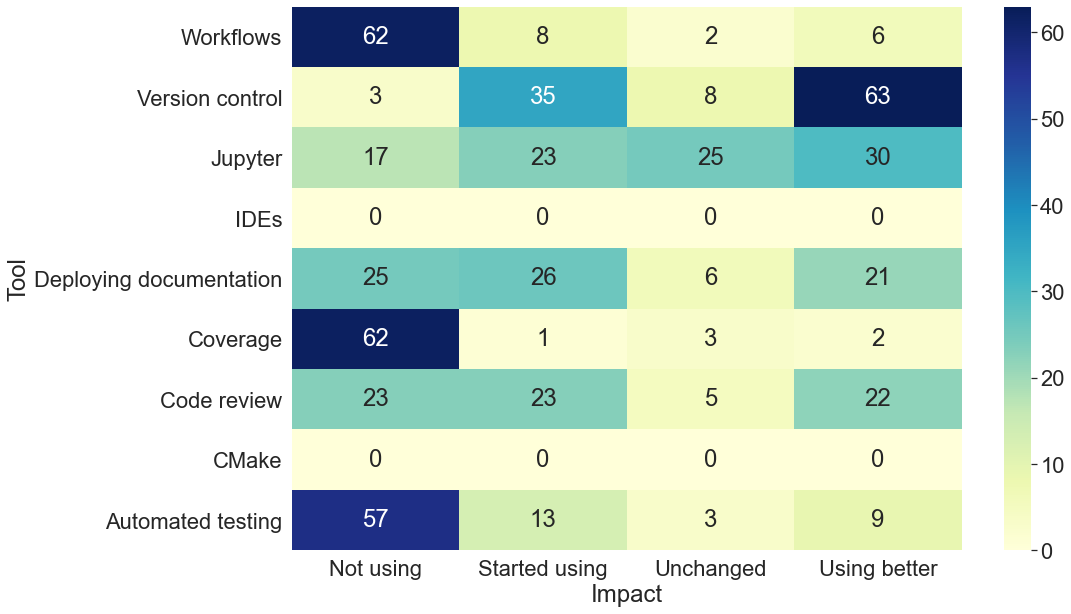

In [163]:
f, ax = plt.subplots(figsize=(15, 10))

g = sns.heatmap(result, fmt="g", cmap="YlGnBu", annot=True)
g.set_yticklabels(g.get_yticklabels(), rotation=0) 

f.savefig("figures/heatmap-online.png", bbox_inches = 'tight')